# Semantic Segmentation Lab

Jun Zhu
----

In this notebook, we will build a segmentation network to track VIP in an image. We use the data set for one of the projects at RoboND, Udacity. However, we have implemented different models. One is the original [SegNet](https://arxiv.org/pdf/1511.00561.pdf) and the other has a similar structure but all the convolutional layers are replaced by [depthwise separable convolutional layers](https://arxiv.org/pdf/1610.02357.pdf). However, due to technical constraint, **we have not combined the pooling indices in the encoder to the decoder!!!**

In [1]:
import os
import glob
import sys
import imageio
import random

import numpy as np

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

## Data Visualization<a id='data_vis'></a>

In [2]:
def show_images(image_files, mask_files, n_col=4):
    """Visualze the image and mask"""
    fig, ax = plt.subplots(2, n_col, figsize=(n_col*3.5, 7))
    img_ax = ax[0, :]
    msk_ax = ax[1, :]
    for i_ax, m_ax in zip(img_ax, msk_ax):
        # Ensure we have all the classes in the image
        count = 0
        while True:
            count += 1                
            idx = random.choice(range(len(image_files)))
            if count > 100 or np.sum(np.sum(imageio.imread(mask_files[idx]), axis=0), axis=0).all() > 0:
                break
                
        i_ax.imshow(imageio.imread(image_files[idx]))
        i_ax.set_title(os.path.basename(image_files[idx]))
        m_ax.imshow(imageio.imread(mask_files[idx]))
        m_ax.set_title(os.path.basename(mask_files[idx]))

### Visualize the training data.

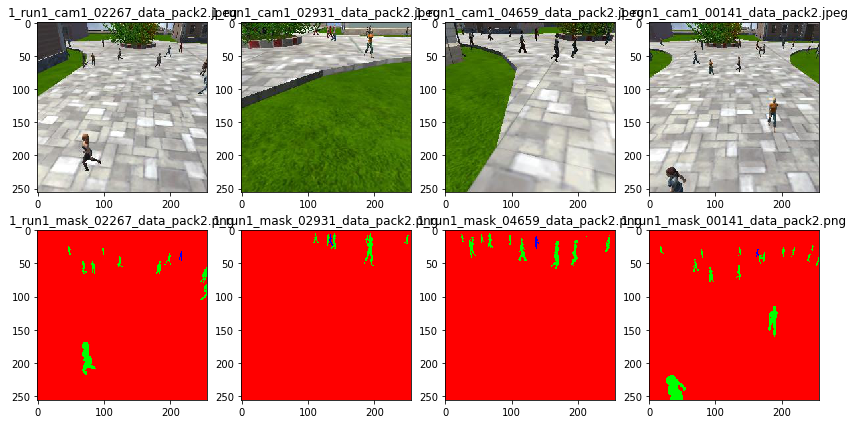

In [3]:
from parameters import train_images, train_masks

show_images(train_images, train_masks)

### Visualize the validation data.

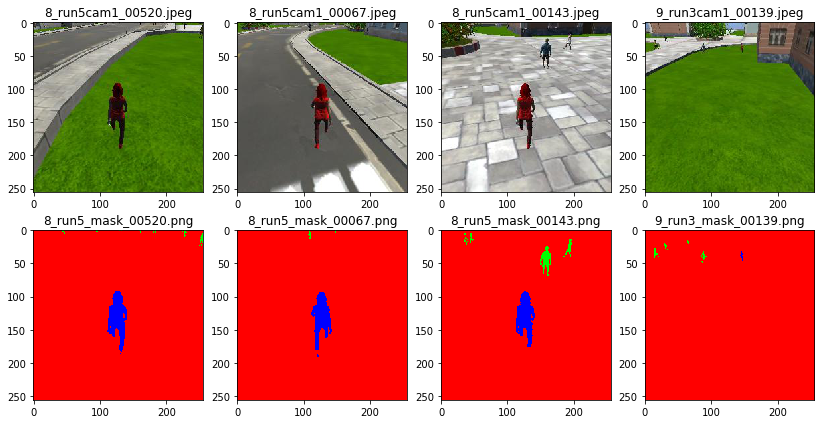

In [4]:
from parameters import vali_images, vali_masks

show_images(vali_images, vali_masks)

## Inference

### Depthwise segnet

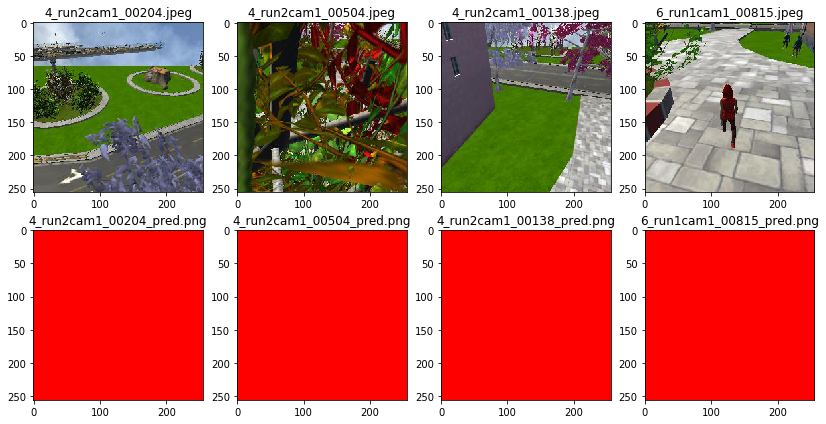

In [5]:
from parameters import test_images

output_folder = "output_depthwise_segnet"
pred_images = sorted(glob.glob(os.path.join(output_folder, "*.png")))

show_images(test_images, pred_images)

###  Segnet

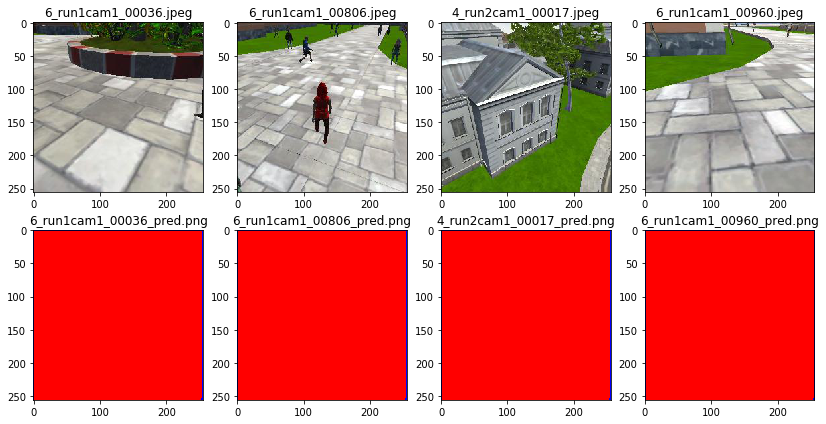

In [6]:
from parameters import test_images

output_folder = "output_segnet"
pred_images = sorted(glob.glob(os.path.join(output_folder, "*.png")))

show_images(test_images, pred_images)